In [1]:
import random
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset
import sys
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import networkx as nx 


In [2]:
# Add the parent directory of 'src' to the Python path
sys.path.append('/ranjan/graphtransformer/my_project')  

In [118]:
# all modules will be reloaded automatically before executing any code.
%load_ext autoreload
%autoreload 2

# Import custom  modules
from src.data_processing import load_cora_data, partition_graph
from src.embedding import mean_pooling, compute_laplacian_positional_embedding, compute_gcn_embeddings
from src.transformer import GraphTransformer
from src.trainer import train_model, evaluate_model
from src.utils import visualize_subgraphs, visualize_graph

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Step 1: Load the Cora dataset

Dataset Loaded: Cora, Number of Graphs: 1
Graph Info:
Nodes: 2708, Edges: 10556, Features: 1433


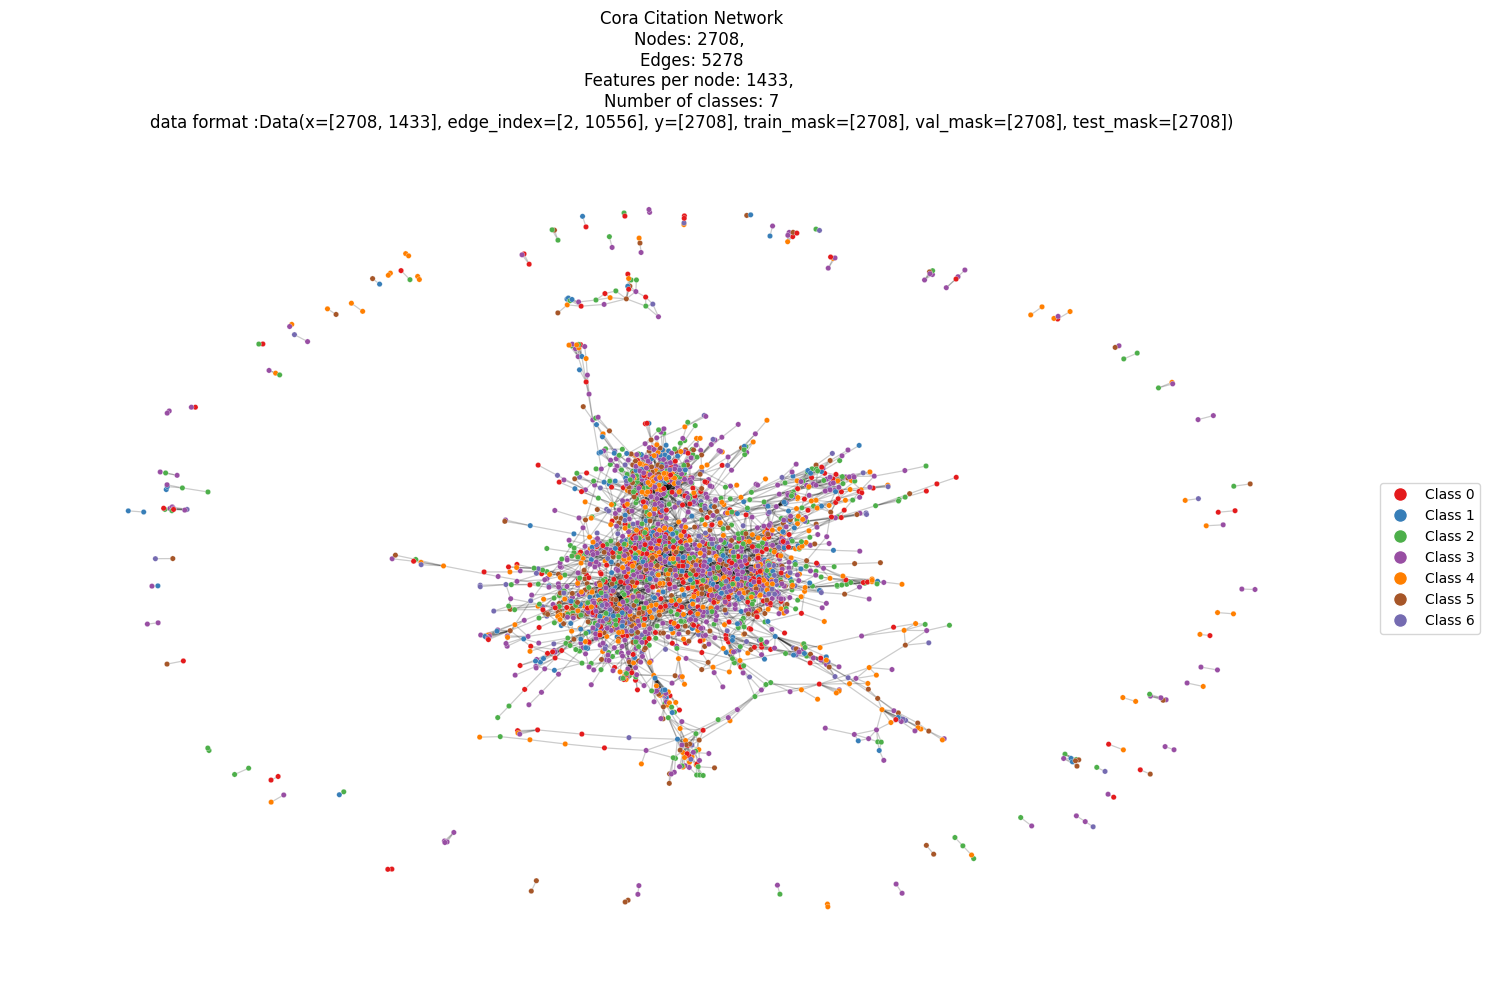

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

In [88]:
graph = load_cora_data()
print(f"Graph Info:\nNodes: {graph.num_nodes}, Edges: {graph.num_edges}, Features: {graph.num_node_features}")

# visualize_graph(graph)

graph

In [5]:
graph.train_mask

tensor([ True,  True,  True,  ..., False, False, False])

-  `graph.train_mask` is likely a boolean mask indicating which nodes in the Cora dataset are used for training.
- This mask is commonly used in machine learning tasks to separate the dataset into training, validation, and test sets.
- By applying this mask, you can filter out the nodes that are designated for training purposes.

# Step 2: Partition the graph into subgraphs

In [165]:
num_parts = 10  # it is no of subgraph
cluster_data = partition_graph(graph, num_parts=num_parts)

cluster_data

Graph partitioned into 10 subgraphs.


Computing METIS partitioning...
Done!


ClusterData(10)

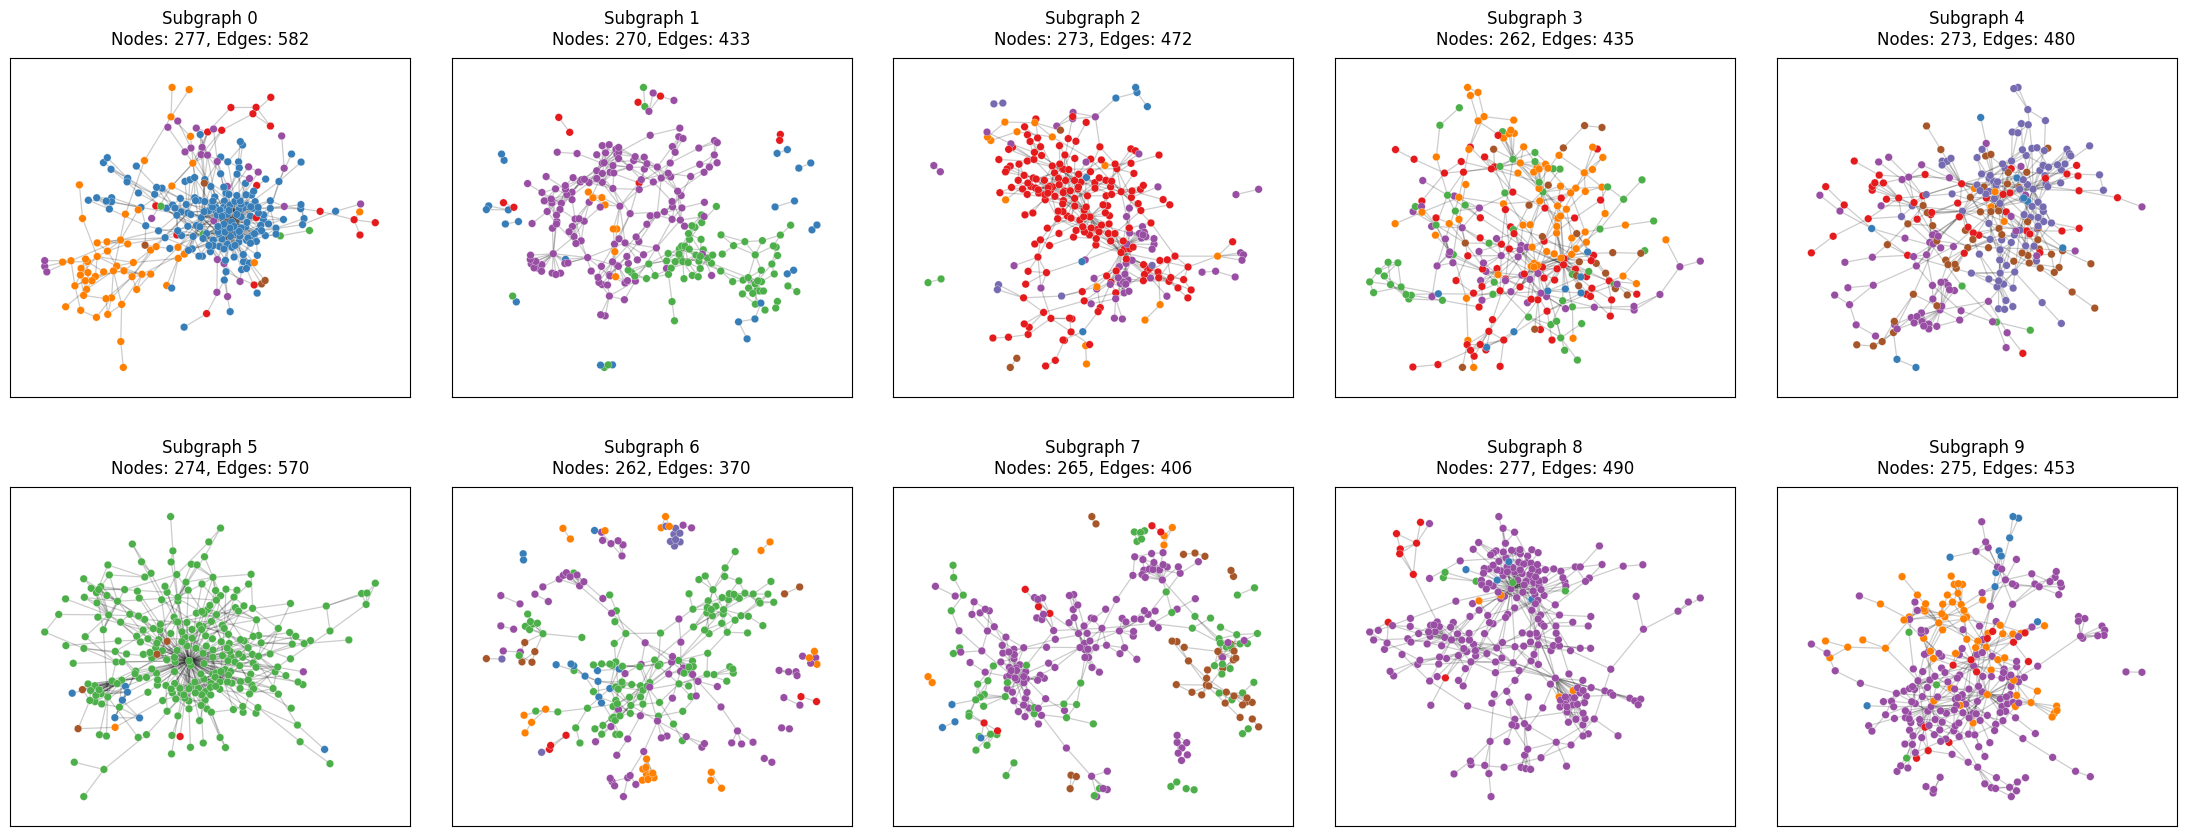

None


In [164]:
visualize_subgraphs(cluster_data, num_plots=num_parts)

---

# Step 3: Compute embeddings and track mask information

In [163]:
subgraph_embeddings = []
lpe_embeddings = []
node_labels = []
num_nodes_list = []
train_masks = []
val_masks = []
test_masks = []

for i in range(num_parts):
    subgraph = cluster_data[i]

    print(f"Subgraph {i} - Number of nodes: {subgraph.num_nodes}")
    print(f"Subgraph {i} - Feature vector size: {subgraph.x.size(1)}")
        
    # Compute GCN embeddings
    gcn_embeddings = compute_gcn_embeddings(subgraph, input_dim=1433, hidden_dim=64, output_dim=16)
        
    # Compute Laplacian positional embeddings
    lpe = compute_laplacian_positional_embedding(subgraph, embedding_dim=16)
        
    # Compute subgraph-level embeddings using mean pooling
    subgraph_embedding = mean_pooling(gcn_embeddings)
    
    # Append subgraph-level embeddings and labels
    subgraph_embeddings.append(subgraph_embedding)
    lpe_embeddings.append(lpe.mean(dim=0))  # Mean pooling for LPE as well
    node_labels.append(subgraph.y)
    num_nodes_list.append(subgraph.num_nodes)
    
    # Store the masks for each subgraph
    train_masks.append(subgraph.train_mask)
    val_masks.append(subgraph.val_mask)
    test_masks.append(subgraph.test_mask)
    
    # Debugging prints to check tensor sizes
    print(f"Subgraph {i} - GCN Embeddings Size: {gcn_embeddings.size()}")
    print(f"Subgraph {i} - LPE Size: {lpe.size()}")
    print(f"Subgraph {i} - Subgraph Embedding Size: {subgraph_embedding.size()}")
    print(f"Subgraph {i} - Node Labels Size: {subgraph.y.size()}")
    print(f"\n Subgraph {i} - train_masks: {train_masks,gcn_embeddings.size()}")
    print("="*100)


subgraph_embeddings = torch.stack(subgraph_embeddings)
lpe_embeddings = torch.stack(lpe_embeddings)
node_labels = torch.cat(node_labels, dim=0)
num_nodes_list = torch.tensor(num_nodes_list)

Subgraph 0 - Number of nodes: 277
Subgraph 0 - Feature vector size: 1433
Subgraph 0 - GCN Embeddings Size: torch.Size([277, 16])
Subgraph 0 - LPE Size: torch.Size([277, 16])
Subgraph 0 - Subgraph Embedding Size: torch.Size([16])
Subgraph 0 - Node Labels Size: torch.Size([277])
Subgraph 1 - Number of nodes: 270
Subgraph 1 - Feature vector size: 1433
Subgraph 1 - GCN Embeddings Size: torch.Size([270, 16])
Subgraph 1 - LPE Size: torch.Size([270, 16])
Subgraph 1 - Subgraph Embedding Size: torch.Size([16])
Subgraph 1 - Node Labels Size: torch.Size([270])
Subgraph 2 - Number of nodes: 273
Subgraph 2 - Feature vector size: 1433
Subgraph 2 - GCN Embeddings Size: torch.Size([273, 16])
Subgraph 2 - LPE Size: torch.Size([273, 16])
Subgraph 2 - Subgraph Embedding Size: torch.Size([16])
Subgraph 2 - Node Labels Size: torch.Size([273])
Subgraph 3 - Number of nodes: 262
Subgraph 3 - Feature vector size: 1433
Subgraph 3 - GCN Embeddings Size: torch.Size([262, 16])
Subgraph 3 - LPE Size: torch.Size([26

- `torch.stack(subgraph_embeddings)` is stacking a list of PyTorch tensors along a new dimension. 
- This operation creates a new tensor by concatenating the input tensors along the specified dimension. 
- In this case, `subgraph_embeddings` is a list of PyTorch tensors, and `torch.stack(subgraph_embeddings)` will stack these tensors along a new dimension to create a single tensor.


## subgraph_embeddings

Subgraph Embeddings:
tensor([[-2.2818e-03, -1.4716e-03, -2.3613e-03, -2.5147e-04, -8.0518e-04,
          2.8122e-03, -2.9936e-03,  1.4158e-03,  3.8378e-03, -1.4822e-03,
         -4.3356e-03, -1.0759e-03, -2.2694e-04,  1.4997e-03,  2.8535e-03,
         -1.6803e-03],
        [-1.1742e-02,  7.0234e-03, -7.4879e-03,  7.9581e-04,  3.7080e-03,
          7.1176e-03, -5.2193e-03, -1.4053e-03,  1.0145e-03,  5.8385e-03,
          1.2437e-03, -1.6169e-03,  5.5935e-03,  5.0555e-03, -1.2987e-03,
          3.8852e-03],
        [ 1.5938e-03, -3.7641e-03,  1.4057e-03, -1.1105e-03, -5.5306e-03,
          5.7126e-03, -2.8069e-03, -8.4533e-04, -1.7800e-03, -4.0525e-03,
         -2.3676e-03,  3.4126e-03, -3.0442e-03, -4.1959e-03,  2.0105e-03,
          7.0329e-04],
        [ 4.8270e-03,  2.3755e-03, -3.8072e-03, -1.7569e-03,  1.1938e-03,
          1.6174e-03,  2.0621e-04, -2.0139e-03,  7.4541e-04, -1.4029e-03,
         -3.7234e-03,  2.2264e-03,  5.3601e-04, -2.8089e-03, -1.4174e-03,
         -5.6838e-04],

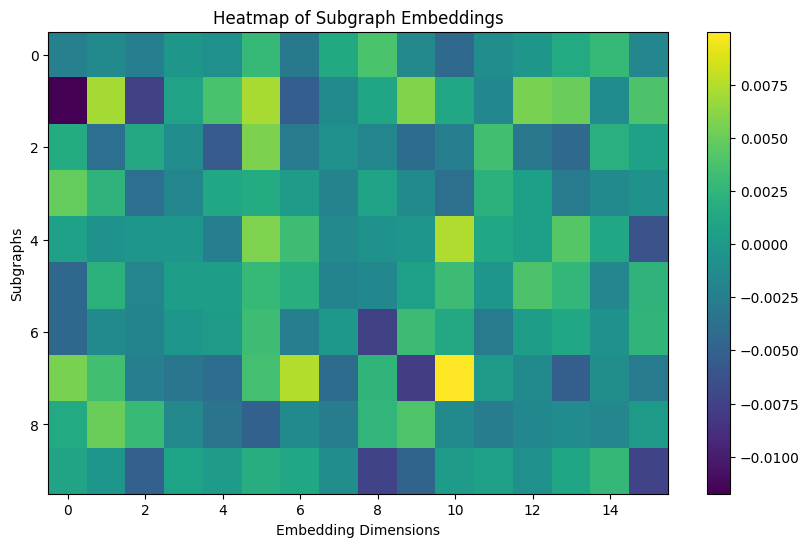

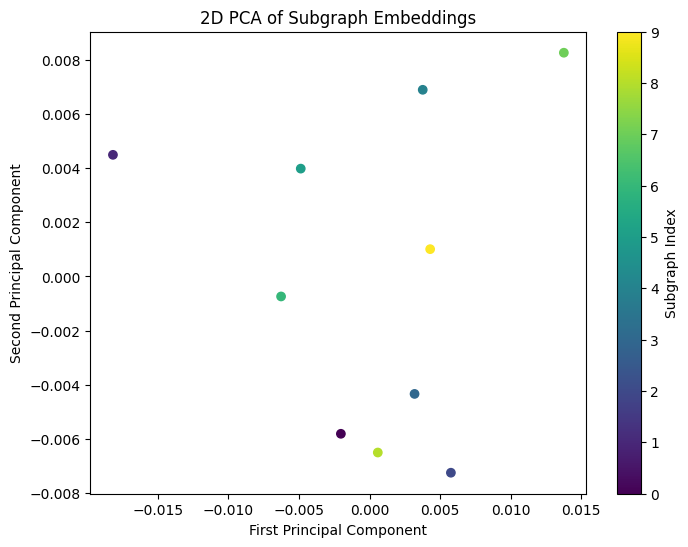

In [166]:
print(f"Subgraph Embeddings:\n{subgraph_embeddings}\n")
print(f"Shape: {subgraph_embeddings.shape}  (represents : {subgraph_embeddings.shape[0]} subgraphs with {subgraph_embeddings.shape[1]} features each)")
print(f"Number of dimensions: {subgraph_embeddings.ndim}")

# Create a heatmap of subgraph embeddings
plt.figure(figsize=(10, 6))
plt.imshow(subgraph_embeddings.detach().numpy(), aspect='auto', cmap='viridis')
plt.colorbar()
plt.title('Heatmap of Subgraph Embeddings')
plt.xlabel('Embedding Dimensions')
plt.ylabel('Subgraphs')
plt.show()

# Perform PCA for 2D visualization
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(subgraph_embeddings.detach().numpy())

# Plot PCA results
plt.figure(figsize=(8, 6))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=range(len(embeddings_2d)))
plt.colorbar(label='Subgraph Index')
plt.title('2D PCA of Subgraph Embeddings')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.show()


## lpe_embeddings

Laplacian Positional Embeddings (LPE):
tensor([[ 6.0084e-02,  1.4247e-06,  7.6464e-07,  2.7438e-07, -1.3879e-07,
          5.0201e-07, -2.1970e-07,  1.1136e-07, -1.0759e-08,  8.8546e-08,
         -6.3854e-08, -6.0250e-09,  6.4339e-08, -2.4638e-08,  2.1518e-09,
          4.1556e-07],
        [ 2.0986e-03,  7.0055e-03,  1.9253e-03,  1.6495e-02,  5.9485e-03,
         -1.2945e-03, -4.0131e-03,  3.9603e-03, -2.6448e-02,  7.5664e-03,
         -8.7734e-03, -1.0007e-02,  4.5855e-03, -3.0183e-03,  2.7702e-03,
          7.1842e-03],
        [-6.3360e-03,  5.6681e-02, -2.3597e-03,  1.0753e-03, -4.9609e-03,
          8.5688e-03,  4.6891e-03, -2.4502e-03, -1.6654e-02, -6.9659e-07,
         -1.9524e-07,  3.1822e-07, -2.6213e-07,  1.4833e-07, -1.2671e-07,
          3.1549e-08],
        [-6.1780e-02,  3.1416e-06, -4.6467e-07,  9.8254e-07,  1.1810e-07,
          3.3346e-07,  1.4674e-08, -8.8014e-08,  1.1278e-07, -3.9767e-07,
          8.9179e-08,  3.4381e-08, -1.1466e-07,  6.7795e-08,  1.1790e-07,
    

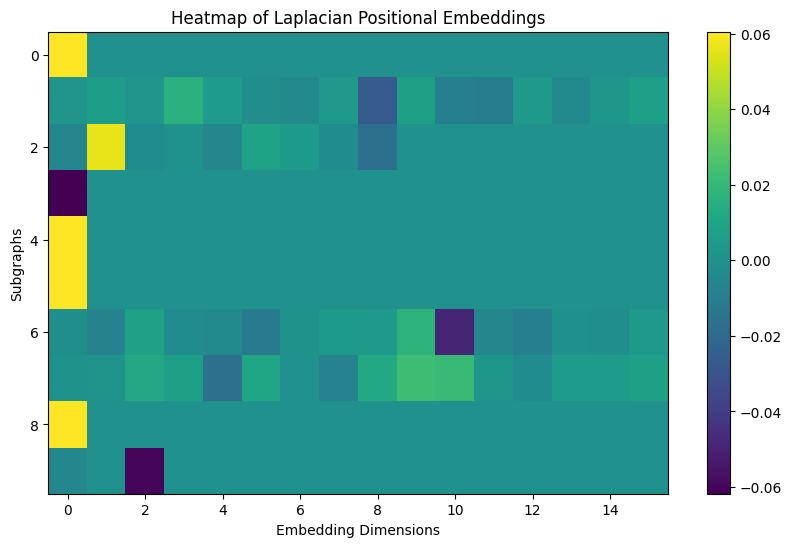

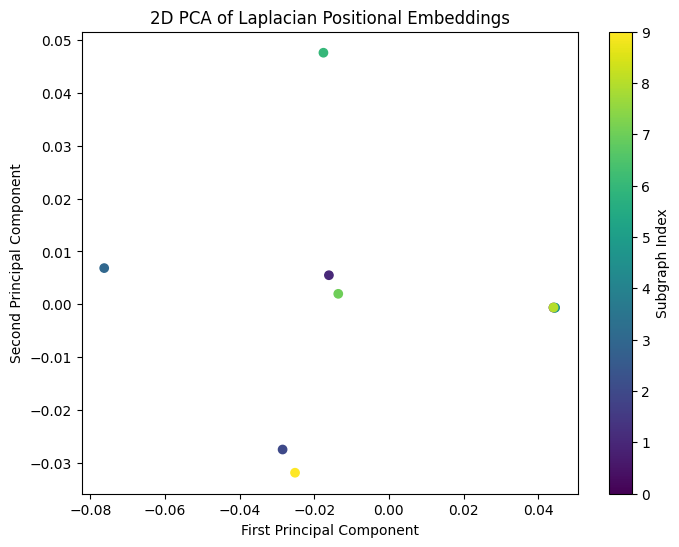

In [167]:
print(f"Laplacian Positional Embeddings (LPE):")
print(lpe_embeddings)
print(f"Shape: {lpe_embeddings.shape} (represents: {lpe_embeddings.shape[0]} subgraphs with {lpe_embeddings.shape[1]} embedding dimensions)")
print(f"Number of dimensions: {lpe_embeddings.ndim}")
# Create a heatmap of LPE embeddings
plt.figure(figsize=(10, 6))
plt.imshow(lpe_embeddings.detach().numpy(), aspect='auto', cmap='viridis')
plt.colorbar()
plt.title('Heatmap of Laplacian Positional Embeddings')
plt.xlabel('Embedding Dimensions')
plt.ylabel('Subgraphs')
plt.show()

# Perform PCA for 2D visualization
pca = PCA(n_components=2)
lpe_2d = pca.fit_transform(lpe_embeddings.detach().numpy())

# Plot PCA results
plt.figure(figsize=(8, 6))
plt.scatter(lpe_2d[:, 0], lpe_2d[:, 1], c=range(len(lpe_2d)))
plt.colorbar(label='Subgraph Index')
plt.title('2D PCA of Laplacian Positional Embeddings')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.show()


## node_labels

In [168]:
print("Node Labels Information:")
print(f"Labels: {node_labels}")
print(f"Shape: {node_labels.shape} (represents total number of nodes across all subgraphs)")
print(f"Number of dimensions: {node_labels.ndim}")

Node Labels Information:
Labels: tensor([4, 1, 4,  ..., 4, 0, 3])
Shape: torch.Size([2708]) (represents total number of nodes across all subgraphs)
Number of dimensions: 1


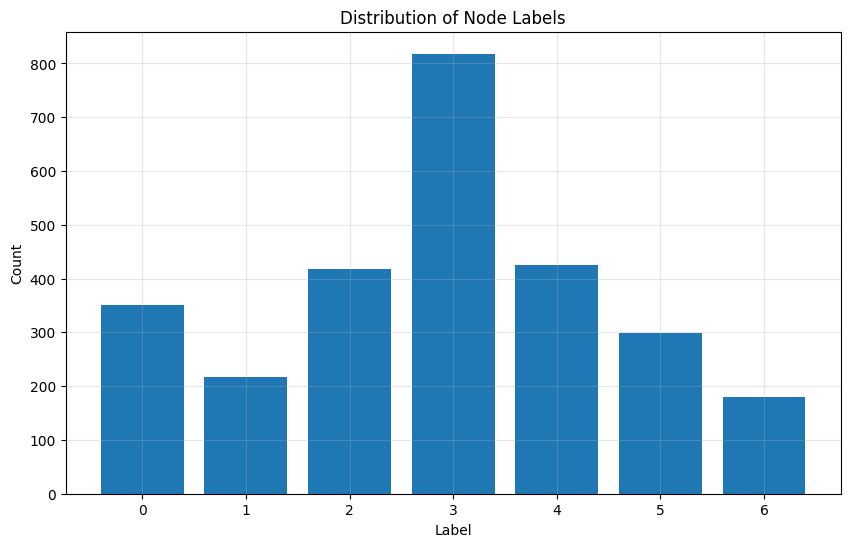

Label distribution: [(0, 351), (1, 217), (2, 418), (3, 818), (4, 426), (5, 298), (6, 180)]


In [169]:
# Get unique labels and their counts
unique_labels = torch.unique(node_labels)
label_counts = [(l.item(), (node_labels == l).sum().item()) for l in unique_labels]

# Create bar plot
plt.figure(figsize=(10, 6))
plt.bar([str(label) for label, count in label_counts], [count for label, count in label_counts])
plt.title('Distribution of Node Labels')
plt.xlabel('Label')
plt.ylabel('Count')
plt.grid(True, alpha=0.3)
plt.show()

print(f"Label distribution: {[(l.item(), (node_labels == l).sum().item()) for l in torch.unique(node_labels)]}")

## num_nodes_list

Number of nodes in each subgraph: tensor([27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 28, 27, 27, 27, 27, 27, 27, 27,
        27, 27, 27, 27, 28, 27, 27, 28, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27,
        27, 27, 27, 28, 28, 27, 27, 27, 27, 27, 27, 28, 27, 27, 27, 27, 27, 27,
        27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 28, 27, 28, 27,
        27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 26, 28, 27, 27, 27,
        27, 27, 27, 27, 27, 27, 27, 27, 27, 27])
Shape: torch.Size([100]) (represents 100 subgraphs)
Number of dimensions: 1


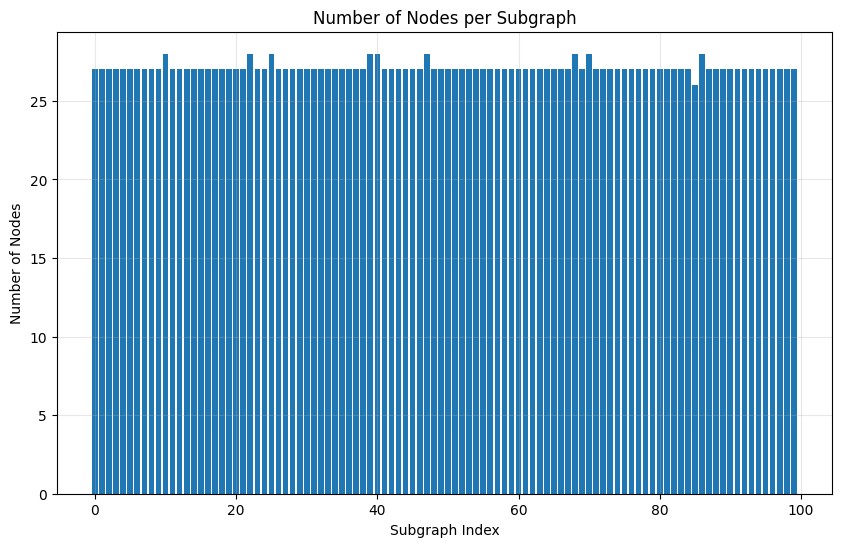

Average nodes per subgraph: 27.08
Min nodes: 26
Max nodes: 28


In [ ]:
print(f"Number of nodes in each subgraph: {num_nodes_list}")
print(f"Shape: {num_nodes_list.shape} (represents {num_nodes_list.shape[0]} subgraphs)")  
print(f"Number of dimensions: {num_nodes_list.ndim}")

# Create a bar plot of nodes per subgraph
plt.figure(figsize=(10, 6))
plt.bar(range(len(num_nodes_list)), num_nodes_list.numpy())
plt.title('Number of Nodes per Subgraph')
plt.xlabel('Subgraph Index')
plt.ylabel('Number of Nodes')
plt.grid(True, alpha=0.3)
plt.show()

# Calculate and print statistics
print(f"Average nodes per subgraph: {num_nodes_list.float().mean():.2f}")
print(f"Min nodes: {num_nodes_list.min()}")
print(f"Max nodes: {num_nodes_list.max()}")